<a href="https://colab.research.google.com/github/yuncaich/TFG_Proyect/blob/main/Codigo_TFG/medMnist_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<h1>Instalamos los paquetes de datos

In [2]:
!pip install medmnist
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.4 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=e0e6d403777311a982509e602788944470238e845e189b14cf99eeb5538d6160
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import Augmentor
import medmnist
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot
from Augmentor import Operations as AugOper
from PIL import Image
from medmnist import INFO, Evaluator
from torch.utils.data import WeightedRandomSampler
from torchvision.models import vgg16_bn
from torchvision.models import densenet201
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter

<h1>Hiperparametros




In [4]:
data_flag = 'dermamnist'

NUM_EPOCHS = 10
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = info['label']

DataClass = getattr(medmnist, info['python_class'])

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
info

{'python_class': 'DermaMNIST',
 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/dermamnist.npz?download=1',
 'MD5': '0744692d530f8e62ec473284d019b0c7',
 'task': 'multi-class',
 'label': {'0': 'actinic keratoses and intraepithelial carcinoma',
  '1': 'basal cell carcinoma',
  '2': 'benign keratosis-like lesions',
  '3': 'dermatofibroma',
  '4': 'melanoma',
  '5': 'melanocytic nevi',
  '6': 'vascular lesions'},
 'n_channels': 3,
 'n_samples': {'train': 7007, 'val': 1003, 'test': 2005},
 'license': 'CC BY 4.0'}

<h1>Dataloader , Sampler y Augmentor

In [109]:
# normalize
# preprocessing
data_transform = transforms.Compose([
    # transforms.Resize((64,64)),                    #Descomentar en caso de usar modelo VGG y comentar en caso de NET
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_test_transform = transforms.Compose([
    # transforms.Resize((64,64)),                     #Descomentar en caso de usar modelo VGG y comentar en caso de NET
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_test_transform, download=True)
val_dataset = DataClass(split='val',transform=data_test_transform, download=True)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


<h1> Weighted Sampler

In [49]:
def sampler_weight(datasets):
  N = len(datasets)
  N0 = 0
  N1 = 0
  N2 = 0
  N3 = 0
  N4 = 0
  N5 = 0
  N6 = 0

  for i, j in datasets:
    for x in j:
      if x.item() == 0:
        N0 += 1
      if x.item() == 1:
        N1 += 1
      if x.item() == 2:
        N2 += 1
      if x.item() == 3:
        N3 += 1
      if x.item() == 4:
        N4 += 1
      if x.item() == 5:
        N5 += 1
      if x.item() == 6:
        N6 += 1  

  class_weights = [N/N0, N/N1, N/N2, N/N3, N/N4, N/N5, N/N6]
  sample_weights = [0] * len(train_dataset)
  for id , (data, targets) in enumerate(datasets):
    class_weight = class_weights[targets.item()]
    sample_weights[id] = class_weight

  sampler = WeightedRandomSampler(sample_weights , num_samples=N , replacement=True)
  return sampler


In [81]:
#  Descomentar si quieres WeightedSampler

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False,sampler=sampler_weight(train_dataset))
train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [110]:

# # encapsulate data into dataloader form  
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<h1>Focal Loss

In [51]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2, size_average = True):
    super(FocalLoss, self).__init__()
    self.size_average = size_average
    self.alpha = alpha
    self.gamma = torch.Tensor([gamma])
    if isinstance(alpha, (float, int)):
      if self.alpha > 1:
        raise ValueError('Not supported value, alpha should be small than 1.0')
      else:
        self.alpha = torch.Tensor([alpha, 1.0 - alpha])
    if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
    self.alpha /= torch.sum(self.alpha)

  def forward(self, input, target):
    input= torch.softmax(input,dim=1)
    if input.dim() > 2:
      input = input.view(input.size(0), input.size(1), -1)
      if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
    target = target.view(-1, 1)
    logpt = torch.log(input + 1e-10)
    logpt = logpt.gather(1, target)
    logpt = logpt.view(-1, 1)
    pt = torch.exp(logpt)
    alpha = self.alpha.gather(0, target.view(-1))
 
    gamma = self.gamma
 
    if not self.gamma.device == input.device:
      gamma = torch.tensor(self.gamma, device=input.device)
 
    loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
    if self.size_average:
      loss = loss.mean()
    else:
      loss = loss.sum()
    return loss
    
    

In [52]:
def data_weight(datasets):
  N = len(datasets)
  N0 = 0
  N1 = 0
  N2 = 0
  N3 = 0
  N4 = 0
  N5 = 0
  N6 = 0

  for i, j in datasets:
    for x in j:
      if x.item() == 0:
        N0 += 1
      if x.item() == 1:
        N1 += 1
      if x.item() == 2:
        N2 += 1
      if x.item() == 3:
        N3 += 1
      if x.item() == 4:
        N4 += 1
      if x.item() == 5:
        N5 += 1
      if x.item() == 6:
        N6 += 1  

  class_weights = [N0/N, N1/N, N2/N, N3/N, N4/N, N5/N, N6/N]
  # class_weights = [N/N0, N/N1, N/N2, N/N3, N/N4, N/N5, N/N6]

  return class_weights

<h1>Visualizar

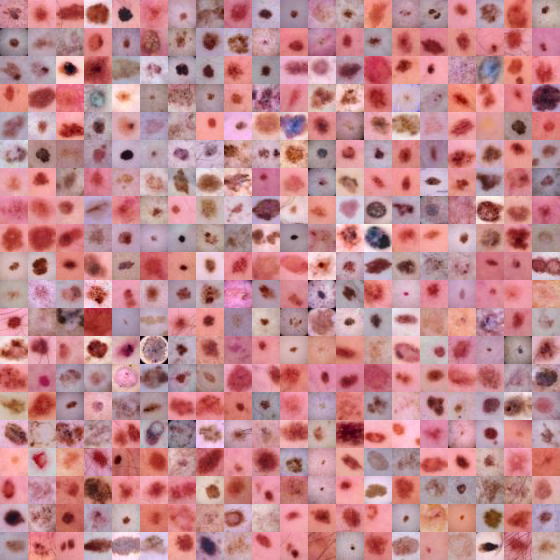

In [ ]:
# visualization

train_dataset.montage()



<h1>Modelo

In [11]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, len(num_classes)))
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
model = Net(in_channels=n_channels, num_classes=n_classes)
model

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

<h1>Funcion de Perdida

In [ ]:


# # criterion = nn.CrossEntropyLoss()

# criterion = FocalLoss(data_weight(train_dataset) , gamma = 0)

    
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

<h1>Entrenar

In [82]:
# train

model = vgg16_bn().to(device)
# model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
# model = resnet152().to(device)
# model = densenet201().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()



best_valid_loss = float('inf')
tb_log = SummaryWriter('drive/MyDrive/Logs_VGG_WEighted/test_{}'.format("crossentropy_weighted"))

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = []
    for idx, (inputs, targets) in enumerate(tqdm(train_loader)):
          # forward + backward + optimize
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
          
              
        if task == 'multi-label, binary-class':
                targets = targets.to(torch.int64)
                loss = criterion(outputs, targets)
        else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
          

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().item())
      
    tb_log.add_scalar('Train/FocalLoss', np.array(epoch_loss).mean(), epoch)

torch.save(model.state_dict(), "/content/drive/MyDrive/Resultado_Clasificacion/VGG_WEighted/crossentropy_weighted")

100%|██████████| 219/219 [00:20<00:00, 10.63it/s]


<h1> Entrenamiento Focal loss

In [86]:
# train

for gamma in [0,0.5,1,2,5]:
  
  model = vgg16_bn().to(device)
  # model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
  # model = resnet152().to(device)
  # model = densenet201().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  criterion = FocalLoss(data_weight(train_dataset) , gamma = gamma).to(device)
  criterion.alpha = criterion.alpha.to(device)

  best_valid_loss = float('inf')
  tb_log = SummaryWriter('drive/MyDrive/log_Res_2022/test_PYTHON_VGG_weigthed_FOCALLOSS{}'.format(gamma))

  for epoch in range(NUM_EPOCHS):
      model.train()
      epoch_loss = []
      for idx, (inputs, targets) in enumerate(tqdm(train_loader)):
          # forward + backward + optimize
          inputs = inputs.to(device)
          targets = targets.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          
              
          if task == 'multi-label, binary-class':
                  targets = targets.to(torch.int64)
                  loss = criterion(outputs, targets)
          else:
                  targets = targets.squeeze().long()
                  loss = criterion(outputs, targets)
          

          loss.backward()
          optimizer.step()
          epoch_loss.append(loss.detach().item())
      
      tb_log.add_scalar('Train/FocalLoss', np.array(epoch_loss).mean(), epoch)

  torch.save(model.state_dict(), "/content/drive/MyDrive/Resultado_Clasificacion/VGG_WEighted/focal_loss_gamma_net_weighted{}".format(gamma))
          
  #print( "Train epoch  : {} \t Loss : {:.6f}".format(epoch , loss.item()))

  0%|          | 0/219 [00:00<?, ?it/s]<ipython-input-51-59c9b3f8c577>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(self.gamma, device=input.device)
100%|██████████| 219/219 [00:20<00:00, 10.59it/s]


<h1>Test

<h3>Cargar el modelo 

In [132]:
# model = vgg16_bn().cuda()      #Descomentar si es modelo vgg
model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
# model = resnet152().to(device)
# model = densenet201().to(device)

model.eval()

model.load_state_dict(torch.load("/content/drive/MyDrive/Resultado_Clasificacion/modelo pytorch/focal_loss_gamma5"))    #Ruta cargar modelo

<All keys matched successfully>

<h3>Definir criterian

In [133]:
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  criterion = FocalLoss(data_weight(train_dataset) , gamma = 5).to(device)           #En caso de focal loss , En gamma poner los valores correspondiente
  criterion.alpha = criterion.alpha.to(device)
  
  # criterion = nn.CrossEntropyLoss()          #En caso de crossEntropy

In [107]:
from prettytable import PrettyTable
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

class ConfusionMatrix(object):

  def __init__(self, num_classes: int, labels: list):
    self.matrix = np.zeros((num_classes,num_classes))
    self.num_classes = num_classes
    self.labels = labels

  def update(self, preds, labels):
    for p, t in zip(preds, labels):
      # p = p.astype(int)
      p = p.numpy().astype(int)
      t = t.astype(int)
      self.matrix[t,p] += 1

  def summary(self):
    #calcular accuracy
    sum_TP = 0
    for i in range(self.num_classes):
      sum_TP += self.matrix[i,i]
      
    acc = sum_TP/np.sum(self.matrix)
    print("The model accuracy is" , acc)

     #Presicion, recal, specificity
    table = PrettyTable()
    table.field_names = ["", "Presicion", "Recall", "Specificity","F-score"]

    for i in range (self.num_classes):
      TP = self.matrix[i,i]
      FP = np.sum(self.matrix[i, :]) - TP
      FN = np.sum(self.matrix[:, i]) - TP
      TN = np.sum(self.matrix) - TP - FP - FN

      Presicion = round(TP / (TP + FP), 3)
      Recall = round(TP / (TP + FN), 3)
      Specificity = round(TN / (TN + FP), 3)
      score = round((2*Presicion*Recall) / (Presicion+Recall),3)

      table.add_row([self.labels[i],Presicion,Recall,Specificity,score])
      
    print(table)
    
  def plot(self):
    matrix = self.matrix
    sumMatrix= []
    newMatrix = np.zeros([self.num_classes,self.num_classes])
    
    for i in range (self.num_classes):
      sumMatrix.append(sum(matrix[i]))

    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        newMatrix[y,x] = round(matrix[y,x]/sumMatrix[y], 2)
        
    
    plt.imshow(newMatrix, cmap=plt.cm.Oranges)

    #X label 
    plt.xticks(range(self.num_classes) , self.labels, rotation=90 , size = "small")
      
    #y label
    plt.yticks(range(self.num_classes) , self.labels)

    #colorbar
    plt.colorbar()
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title("Confusion matrix")      
    ##plt.tight_layout()

    thresh = newMatrix.max() / 2
    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        info = newMatrix[y,x]
        plt.text(x, y, info,                    #escribir valor
                    verticalalignment ='center',
                    horizontalalignment ='center',
                    color = "white" if info > thresh else "black")
        


    plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


model = model.to(device)

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    test_loss = 0.0
    data_loader = train_loader_at_eval if split == 'train' else test_loader
  
    labels = [label for _,label in n_classes.items()]
    confusion = ConfusionMatrix(len(n_classes) , labels)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = torch.softmax(model(inputs), dim=1)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            targets = targets.to(torch.int)
            targets = targets.cpu()
            outputs = outputs.cpu()
            confusion.update(torch.argmax(outputs,dim=1),targets.numpy())

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

  
        targets = targets.squeeze().long()
        outputs = outputs.to(device)
        targets = targets.to(device)
        test_loss += criterion(outputs, targets).item()

        evaluator = Evaluator(data_flag, split)
        
        confusion.plot()
        confusion.summary()
        
        
print('==> Evaluating ...')
#test('train')
test('test')

